In [1]:
from IPython.display import display, Markdown
import spacy
from spacy.language import Language
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

In [2]:
df = pd.read_excel('../../data/raw/OMIEC_NEUROMORPHIC_20_08_24.xls')

In [3]:
class CoOcurrence:
    def __init__(self, abstracts, focus_terms, svg_name='test_file.svg'):
        self.nlp = spacy.load("en_core_web_sm")
        self.abstracts = abstracts
        self.focus_terms = focus_terms
        self.num_focus_terms = len(focus_terms)
        self.svg_name = svg_name
        self.setup_pipeline()
        self.docs = list(self.nlp.pipe(self.abstracts))
        self.focus_term_indices = self.find_focus_term_indices()

    def setup_pipeline(self):
        @Language.component("custom_preprocessing")
        def custom_preprocessing(doc):
            preprocessed_text = self.preprocess_text(doc.text)
            return Doc(self.nlp.vocab, words=preprocessed_text.split())
        
        self.nlp.add_pipe("custom_preprocessing", first=True)
        
        @Language.component("merge_phrases")
        def merge_phrases(doc):
            matches = self.matcher(doc)
            with doc.retokenize() as retokenizer:
                for match_id, start, end in matches:
                    span = Span(doc, start, end, label="COMPOUND")
                    retokenizer.merge(span)
            return doc

        self.nlp.add_pipe("merge_phrases", before="ner")
        self.matcher = PhraseMatcher(self.nlp.vocab)
        patterns = [self.nlp.make_doc(text) for text in ["p-type", "n-type", "vertical-oects", "horizontal-oects"]]
        self.matcher.add("SPECIFIC_TERMS", patterns)

    def preprocess_text(self, text):
        # Substituições específicas
        text = re.sub(r'\bv-OECTs\b', 'vertical-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bv-\s*OECTs\b', 'vertical-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bp-OECTs\b', 'parallel-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bp-\s*OECTs\b', 'parallel-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bp-\s+(and)', r'p-type \1', text)
        text = re.sub(r'\bn-\s+(and)', r'n-type \1', text)
        text = re.sub(r'oects', r'oect', text, flags=re.IGNORECASE)
        text = re.sub(r'omiec', r'omiec', text, flags=re.IGNORECASE)

        # Filtragem de unidades de medida e entidades
        # Isso deve ser feito diretamente sem re-chamar o pipeline do SpaCy
        units = {"V", "V-1", "mV", "μV", "nm", "μm", "ms", "us", "ns"}
        tokens = text.split()
        filtered_tokens = [token for token in tokens if token not in units]

        return " ".join(filtered_tokens)

    def postprocess_tokens(self, tokens):
        processed_tokens = []
        for lemma, pos in tokens:
            if len(lemma) < 2:
                continue
            if pos not in ["NOUN", "ADJ"]:
                continue
            if lemma.isnumeric():
                continue
            processed_tokens.append((lemma, pos))
        
        return processed_tokens

    def find_focus_term_indices(self):
        focus_term_indices = {term: [] for term in self.focus_terms}
        
        for i, doc in enumerate(self.docs):
            doc_lemmas = {token.lemma_ for token in doc if not token.is_stop and not token.is_punct}
            for term in self.focus_terms:
                if term in doc_lemmas:
                    focus_term_indices[term].append(i)
        
        return focus_term_indices

    def analyze(self):
        filtered_tokens = np.concatenate([
            [(token.lemma_, token.pos_) for token in doc if not token.is_stop and not token.is_punct]
            for doc in self.docs
        ])

        filtered_tokens = self.postprocess_tokens(filtered_tokens)

        term_freq = Counter(token[0] for token in filtered_tokens if token[1] in ["NOUN", "ADJ"])

        common_terms = term_freq.most_common(20)

        # Exibir termos mais comuns em Markdown
        md_output_common = "### Termos Mais Comuns\n\n"
        for term, freq in common_terms:
            md_output_common += f"- **{term}**: {freq} ocorrências\n"

        display(Markdown(md_output_common))

        print("\nÍndices dos abstracts onde os focus_terms ocorrem:")
        for term, indices in self.focus_term_indices.items():
            print(f"Termo '{term}' encontrado nos abstracts com índices: {indices}")

        G = nx.Graph()

        edges = [
            (token.lemma_, child.lemma_)
            for doc in self.docs
            for token in doc
            if not token.is_stop and not token.is_punct and token.pos_ in ["NOUN", "ADJ"]
            for child in token.children
            if child.pos_ in ["NOUN", "ADJ"]
        ]
        G.add_edges_from(edges)

        subG = nx.Graph((term, neighbor) for term in self.focus_terms if term in G for neighbor in G.neighbors(term))

        common_nodes = {
            node for node in subG.nodes()
            if sum(1 for term in self.focus_terms if node in nx.neighbors(subG, term)) > 1
        }

        colormap = plt.colormaps['tab10']
        colors = [colormap(i / self.num_focus_terms) for i in range(self.num_focus_terms)]
        focus_term_colors = {term: mcolors.to_hex(color) for term, color in zip(self.focus_terms, colors)}

        blend_colors = lambda colors: mcolors.to_hex(tuple(sum(x)/len(x) for x in zip(*map(mcolors.to_rgb, colors))))

        node_colors = [
            focus_term_colors[node] if node in self.focus_terms else
            blend_colors([focus_term_colors[term] for term in self.focus_terms if node in nx.neighbors(subG, term)]) if node in common_nodes else
            'orange'
            for node in subG.nodes()
        ]

        plt.figure(figsize=(10*self.num_focus_terms, 10*self.num_focus_terms))

        pos = nx.spring_layout(subG, k=0.5, iterations=50)

        nx.draw(
            subG, pos, 
            with_labels=True, 
            node_size=5000, 
            node_color=node_colors, 
            font_size=12, 
            font_weight='bold',
            edge_color='gray', 
            linewidths=1.5, 
            alpha=0.8
        )

        plt.title("Grafo de Co-ocorrências", fontsize=30)
        plt.savefig(f'images/{self.svg_name}')
        plt.show()

        subgraph_terms = set(subG.nodes())
        search_terms = [term for term, _ in common_terms if term in subgraph_terms]

        if not search_terms:
            search_terms = ['>>None<<']

        # Exibir termos recomendados em Markdown
        md_output_search = "### Sugestões de Termos de Busca\n\n"
        for term in search_terms:
            md_output_search += f"- **{term}**\n"

        display(Markdown(md_output_search))

    def show_abstract(self, index):
        return display(Markdown(self.abstracts[index]))

### Termos Mais Comuns

- **organic**: 200 ocorrências
- **neuromorphic**: 171 ocorrências
- **electrochemical**: 169 ocorrências
- **transistor**: 137 ocorrências
- **oect**: 133 ocorrências
- **device**: 122 ocorrências
- **ion**: 87 ocorrências
- **mixed**: 80 ocorrências
- **high**: 74 ocorrências
- **material**: 68 ocorrências
- **electronic**: 65 ocorrências
- **polymer**: 64 ocorrências
- **application**: 63 ocorrências
- **conductor**: 63 ocorrências
- **channel**: 58 ocorrências
- **synaptic**: 58 ocorrências
- **performance**: 50 ocorrências
- **circuit**: 48 ocorrências
- **low**: 48 ocorrências
- **bioelectronic**: 46 ocorrências



Índices dos abstracts onde os focus_terms ocorrem:
Termo 'omiec' encontrado nos abstracts com índices: [1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 16, 18, 19]
Termo 'oect' encontrado nos abstracts com índices: [1, 5, 9, 11, 16, 31, 38, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 70, 71, 73, 74, 75, 76, 79, 80, 82, 83, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113]
Termo 'neuromorphic' encontrado nos abstracts com índices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]

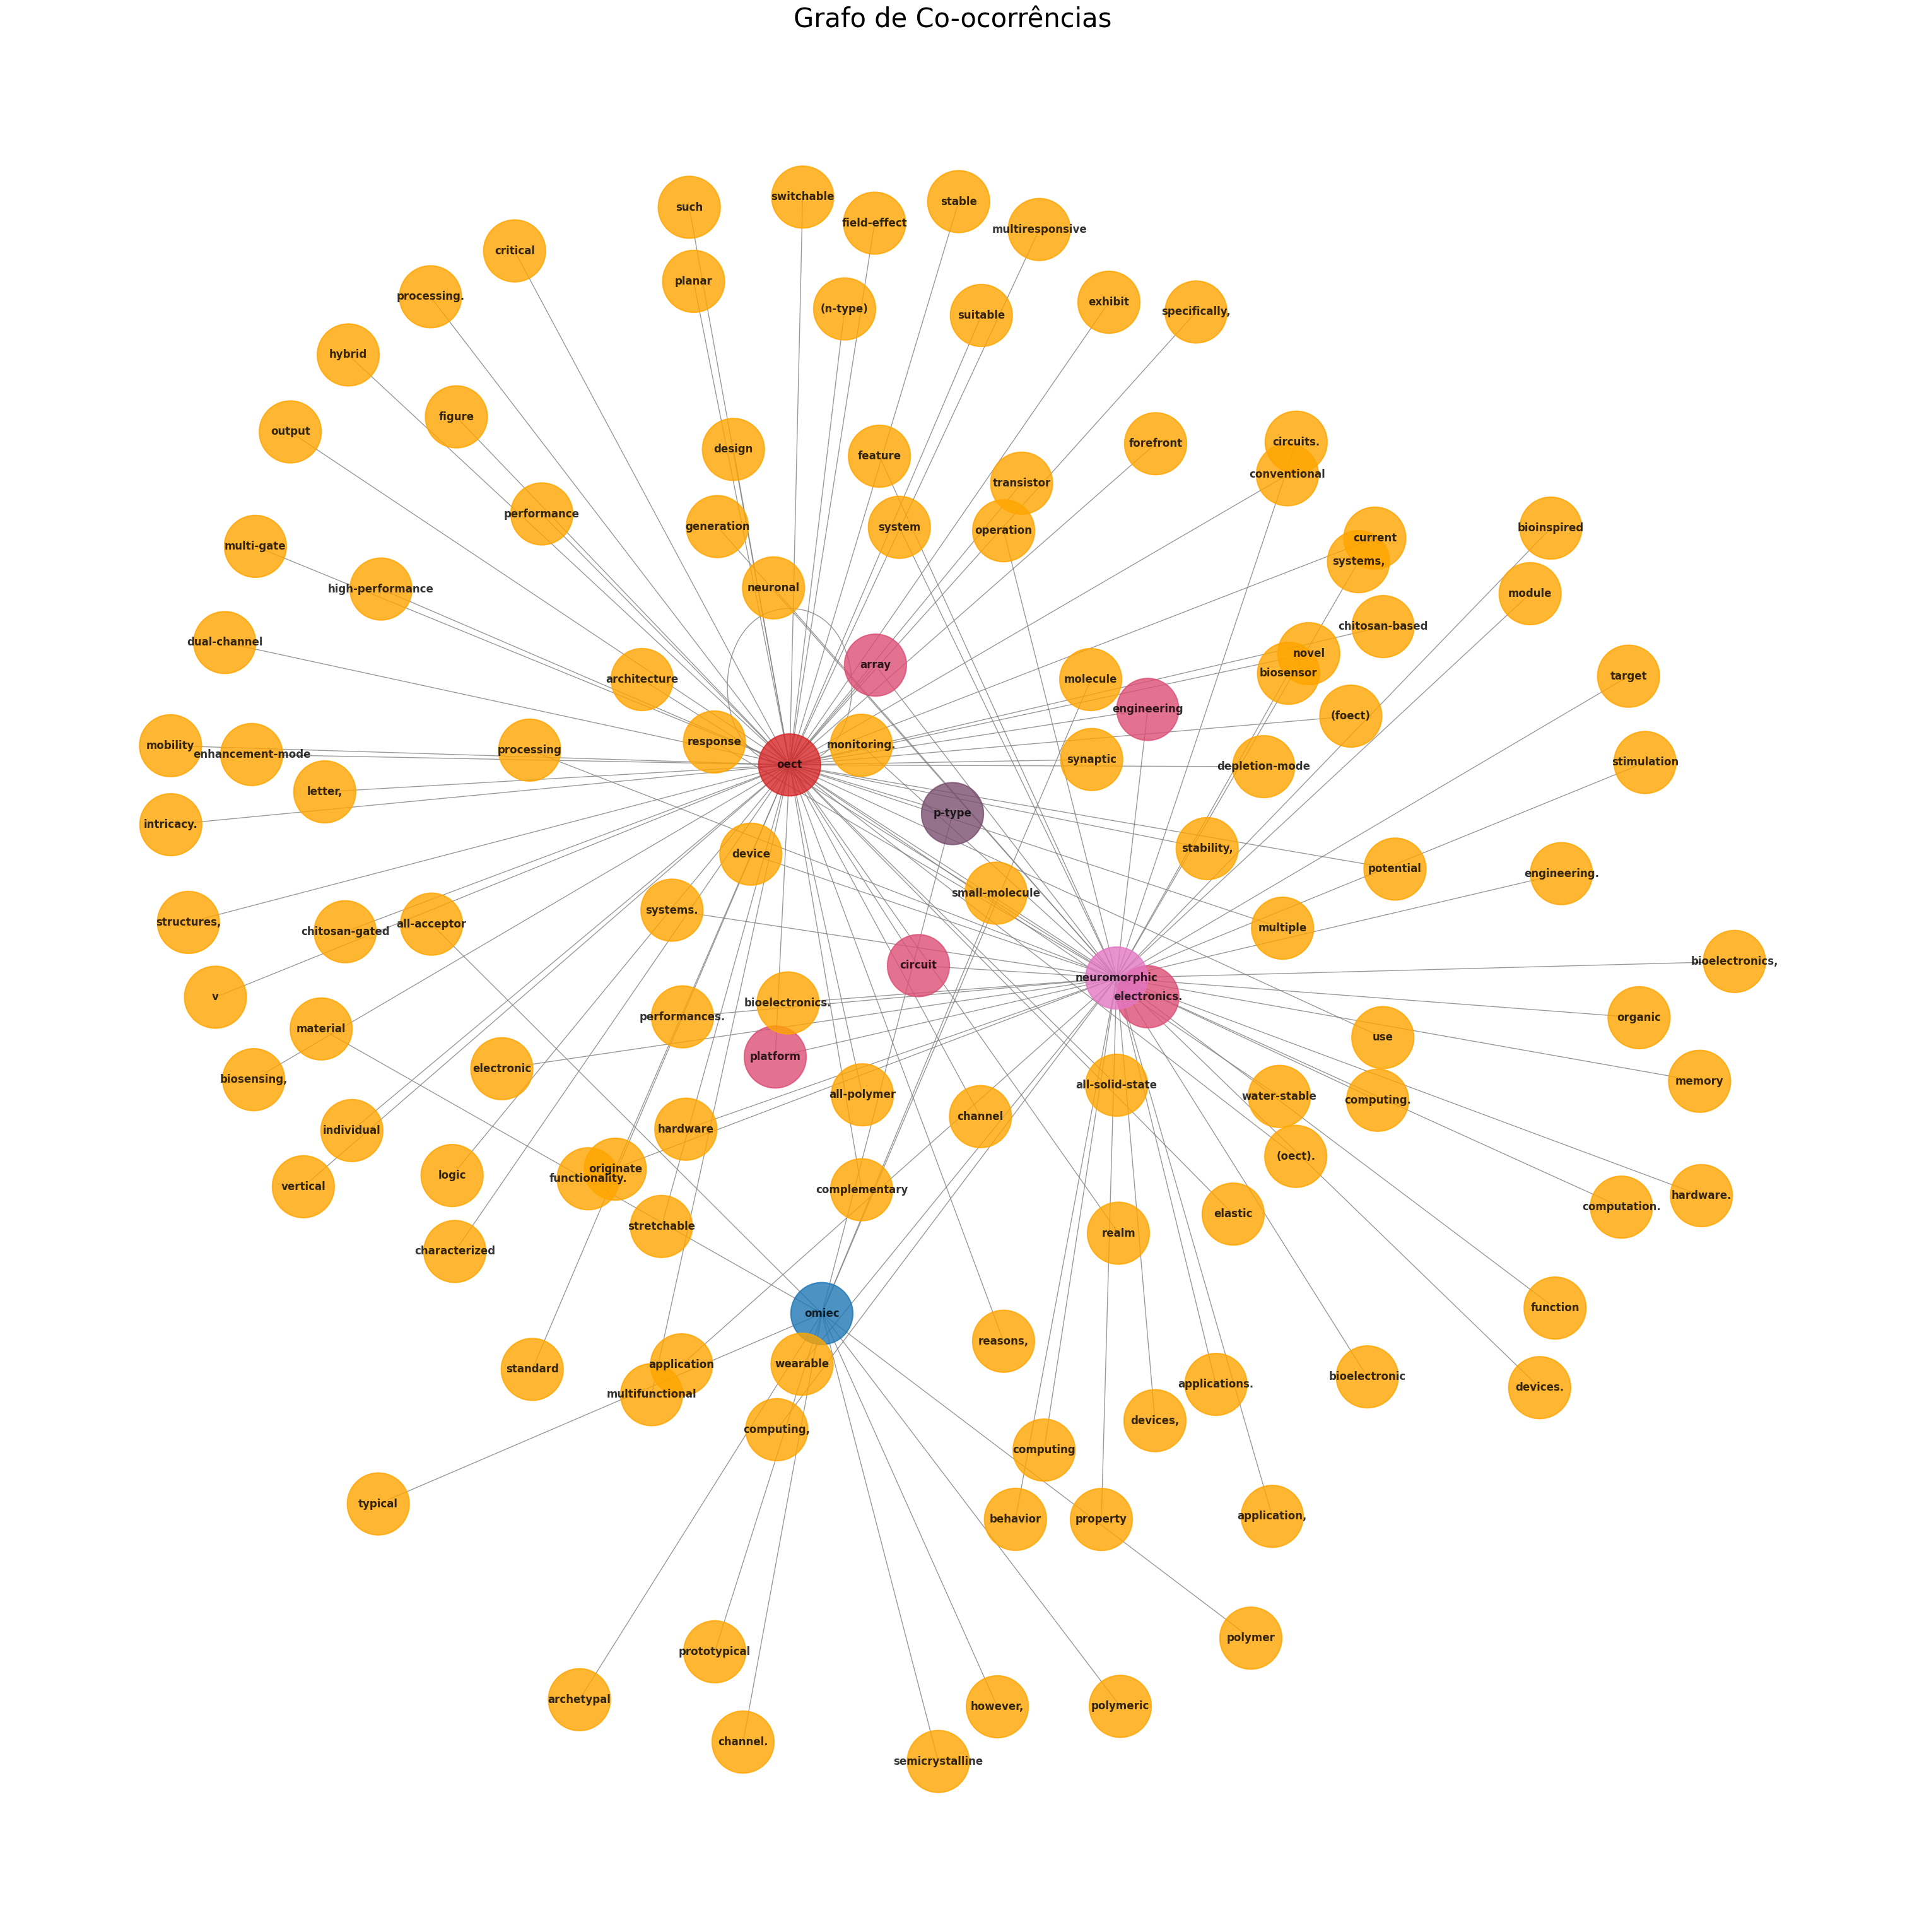

### Sugestões de Termos de Busca

- **organic**
- **neuromorphic**
- **transistor**
- **oect**
- **device**
- **material**
- **electronic**
- **polymer**
- **application**
- **channel**
- **synaptic**
- **performance**
- **circuit**
- **bioelectronic**


In [4]:
focus_terms = ['omiec', 'oect','neuromorphic']  # Substitua pelos termos de interesse

analyzer = CoOcurrence(df['Abstract'], focus_terms,svg_name='grafo_omiec_oect_neuromorphic.svg')
analyzer.analyze()

In [5]:
analyzer.show_abstract(40)

Organic electrochemical transistors (OECTs) using aqueous gate dielectrics have garnered significant interest for bioelectronic applications. However, their viability for long-term use in neuromorphic computing and synaptic devices is limited due to their short-term functionality. In this study, we synthesize two benzodifurandione-based oligo ( p -phenylene vinylene) polymers, BDOPV-TCNVT and ClBDOPV-TCNVT, and investigate their electrochemical transistor properties using quasi -solid-state ion gel -gated vertical OECTs ( v -OECTs). Compared to BDOPV-TCNVT, the chlorinated ClBDOPV-TCNVT demonstrates lower frontier molecular orbitals and easier electrochemical doping. The higher volumetric capacitance of as -spun ClBDOPV-TCNVT (1.94 F cm -3 ) compared to as -spun BDOPV-TCNVT films (1.49 F cm -3 ) is mainly attributed to the easier ion infiltration resulting from its lower crystallinity with mixed chain orientation. The quasi -solid-state v -OECTs based on both polymers (as -spun) exhibit transconductance ( g m ) of 0.06 -0.08 mS. Following thermal treatments, the g m gradually decreases for both polymers due to enhanced edge -on ordering with tight interchain packing, hindering ion penetration. Despite the poor electrochemical doping by quasi -solid-state ion gel gated dielectrics, the enlarged area and decreased channel length in v- OECTs (compared to parallel OECTs) can enhance the g m . Further optimization of v- OECTs requires tailored material designs specifically suited for efficient vertical charge transport together with ion infiltration.

### Playground

In [6]:
from IPython.display import display, Markdown
import spacy
from spacy.language import Language
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

class CoOcurrence:
    def __init__(self, abstracts, focus_terms, svg_name='test_file.svg'):
        self.nlp = spacy.load("en_core_web_sm")
        self.abstracts = abstracts
        self.focus_terms = focus_terms
        self.num_focus_terms = len(focus_terms)
        self.svg_name = svg_name
        self._setup_pipeline()
        self.docs = list(self.nlp.pipe(self.abstracts))
        self.focus_term_indices = self._find_focus_term_indices()

    def _setup_pipeline(self):
        @Language.component("custom_preprocessing")
        def custom_preprocessing(doc):
            preprocessed_text = self.preprocess_text(doc)
            return self.nlp.make_doc(preprocessed_text)
        
        self.nlp.add_pipe("custom_preprocessing", first=True)
        
        @Language.component("merge_phrases")
        def merge_phrases(doc):
            matches = self.matcher(doc)
            with doc.retokenize() as retokenizer:
                for match_id, start, end in matches:
                    span = Span(doc, start, end, label="COMPOUND")
                    retokenizer.merge(span)
            return doc

        self.nlp.add_pipe("merge_phrases", before="ner")
        self.matcher = PhraseMatcher(self.nlp.vocab)
        patterns = [self.nlp.make_doc(text) for text in ["p-type", "n-type"]]
        self.matcher.add("SPECIFIC_TERMS", patterns)

    def preprocess_text(self, doc):
        # Filtra tokens baseados em entidades (QUANTITY, CARDINAL) e remoção de unidades de medida
        tokens = [
            token for token in doc 
            if token.ent_type_ not in {"QUANTITY", "CARDINAL", "PERCENT"} and token.text not in {"V", "V-1", "mV", "μV", "nm", "μm", "ms", "us", "ns"}
        ]
        return " ".join(token.text for token in tokens)

    def postprocess_tokens(self, tokens):
        processed_tokens = []
        for lemma, pos in tokens:
            if len(lemma) < 2:
                continue
            if pos not in ["NOUN", "ADJ"]:
                continue
            if lemma.isnumeric():
                continue
            processed_tokens.append((lemma, pos))
        
        return processed_tokens

    def _find_focus_term_indices(self):
        focus_term_indices = {term: [] for term in self.focus_terms}
        
        for i, doc in enumerate(self.docs):
            doc_lemmas = {token.lemma_ for token in doc if not token.is_stop and not token.is_punct}
            for term in self.focus_terms:
                if term in doc_lemmas:
                    focus_term_indices[term].append(i)
        
        return focus_term_indices

    def analyze(self):
        filtered_tokens = np.concatenate([
            [(token.lemma_, token.pos_) for token in doc if not token.is_stop and not token.is_punct]
            for doc in self.docs
        ])

        filtered_tokens = self.postprocess_tokens(filtered_tokens)

        term_freq = Counter(token[0] for token in filtered_tokens if token[1] in ["NOUN", "ADJ"])

        common_terms = term_freq.most_common(20)

        # Exibir termos mais comuns em Markdown
        md_output_common = "### Termos Mais Comuns\n\n"
        for term, freq in common_terms:
            md_output_common += f"- **{term}**: {freq} ocorrências\n"

        display(Markdown(md_output_common))

        print("\nÍndices dos abstracts onde os focus_terms ocorrem:")
        for term, indices in self.focus_term_indices.items():
            print(f"Termo '{term}' encontrado nos abstracts com índices: {indices}")

        G = nx.Graph()

        edges = [
            (token.lemma_, child.lemma_)
            for doc in self.docs
            for token in doc
            if not token.is_stop and not token.is_punct and token.pos_ in ["NOUN", "ADJ"]
            for child in token.children
            if child.pos_ in ["NOUN", "ADJ"]
        ]
        G.add_edges_from(edges)

        subG = nx.Graph((term, neighbor) for term in self.focus_terms if term in G for neighbor in G.neighbors(term))

        common_nodes = {
            node for node in subG.nodes() 
            if sum(1 for term in self.focus_terms if node in nx.neighbors(subG, term)) > 1
        }

        colormap = plt.colormaps['tab10']
        colors = [colormap(i / self.num_focus_terms) for i in range(self.num_focus_terms)]
        focus_term_colors = {term: mcolors.to_hex(color) for term, color in zip(self.focus_terms, colors)}

        blend_colors = lambda colors: mcolors.to_hex(tuple(sum(x)/len(x) for x in zip(*map(mcolors.to_rgb, colors))))

        node_colors = [
            focus_term_colors[node] if node in self.focus_terms else
            blend_colors([focus_term_colors[term] for term in self.focus_terms if node in nx.neighbors(subG, term)]) if node in common_nodes else
            'orange'
            for node in subG.nodes()
        ]

        plt.figure(figsize=(10*self.num_focus_terms, 10*self.num_focus_terms))

        pos = nx.spring_layout(subG, k=0.5, iterations=50)

        nx.draw(
            subG, pos, 
            with_labels=True, 
            node_size=5000, 
            node_color=node_colors, 
            font_size=12, 
            font_weight='bold',
            edge_color='gray', 
            linewidths=1.5, 
            alpha=0.8
        )

        plt.title("Grafo de Co-ocorrências", fontsize=30)
        plt.savefig(f'images/{self.svg_name}')
        plt.show()

        subgraph_terms = set(subG.nodes())
        search_terms = [term for term, _ in common_terms if term in subgraph_terms]

        if search_terms == []:
            search_terms = ['Not Found']

        # Exibir termos recomendados em Markdown
        md_output_search = "### Sugestões de Termos de Busca\n\n"
        for term in search_terms:
            md_output_search += f"- **{term}**\n"

        display(Markdown(md_output_search))
        

### Termos Mais Comuns

- **organic**: 211 ocorrências
- **device**: 183 ocorrências
- **neuromorphic**: 176 ocorrências
- **electrochemical**: 173 ocorrências
- **oect**: 173 ocorrências
- **transistor**: 153 ocorrências
- **electronic**: 133 ocorrências
- **ion**: 113 ocorrências
- **high**: 112 ocorrências
- **application**: 105 ocorrências
- **material**: 100 ocorrências
- **ionic**: 97 ocorrências
- **performance**: 88 ocorrências
- **mixed**: 83 ocorrências
- **polymer**: 81 ocorrências
- **channel**: 76 ocorrências
- **bioelectronic**: 74 ocorrências
- **computing**: 70 ocorrências
- **conductor**: 70 ocorrências
- **circuit**: 67 ocorrências



Índices dos abstracts onde os focus_terms ocorrem:
Termo 'v-' encontrado nos abstracts com índices: [40]


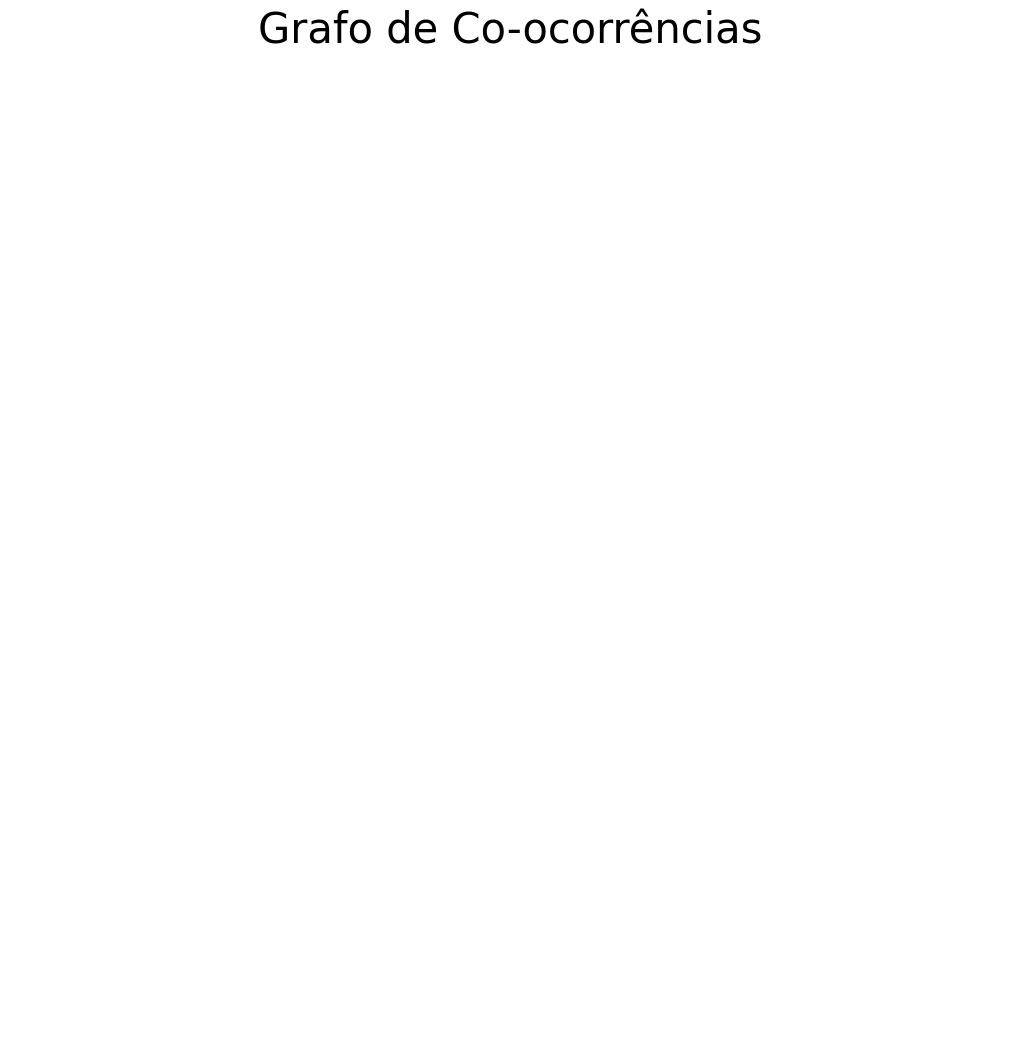

### Sugestões de Termos de Busca

- **Not Found**


In [7]:
focus_terms = ['v-']  # Substitua pelos termos de interesse

analyzer = CoOcurrence(df['Abstract'], focus_terms,svg_name='grafo_omiec_oect_neuromorphic.svg')
analyzer.analyze()

In [24]:
from IPython.display import display, Markdown
import spacy
from spacy.language import Language
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

class CoOcurrence:
    def __init__(self, abstracts, focus_terms, svg_name='test_file.svg'):
        self.nlp = spacy.load("en_core_web_sm")
        self.abstracts = abstracts
        self.focus_terms = focus_terms
        self.num_focus_terms = len(focus_terms)
        self.svg_name = svg_name
        self._setup_pipeline()
        self.docs = list(self.nlp.pipe(self.abstracts))
        self.focus_term_indices = self._find_focus_term_indices()

    def _setup_pipeline(self):
        @Language.component("custom_preprocessing")
        def custom_preprocessing(doc):
            preprocessed_text = self.preprocess_text(doc)
            return self.nlp.make_doc(preprocessed_text)
        
        self.nlp.add_pipe("custom_preprocessing", first=True)
        
        @Language.component("merge_phrases")
        def merge_phrases(doc):
            matches = self.matcher(doc)
            with doc.retokenize() as retokenizer:
                for match_id, start, end in matches:
                    span = Span(doc, start, end, label="COMPOUND")
                    retokenizer.merge(span)
            return doc

        self.nlp.add_pipe("merge_phrases", before="ner")
        self.matcher = PhraseMatcher(self.nlp.vocab)
        patterns = [self.nlp.make_doc(text) for text in ["p-type", "n-type", "vertical-oects", "horizontal-oects"]]
        self.matcher.add("SPECIFIC_TERMS", patterns)

    def preprocess_text(self, doc):
        # Substituições específicas
        text = doc.text
        text = re.sub(r'\bv-OECTs\b', 'vertical-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bv-\s*OECTs\b', 'vertical-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bh-OECTs\b', 'horizontal-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bh-\s*OECTs\b', 'horizontal-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bp-\s+(and)', r'p-type \1', text)
        text = re.sub(r'\bn-\s+(and)', r'n-type \1', text)
        text = re.sub(r'oects', r'oect', text, flags=re.IGNORECASE)
        text = re.sub(r'omiec', r'omiec', text, flags=re.IGNORECASE)

        # Filtra tokens baseados em entidades (QUANTITY, CARDINAL) e remoção de unidades de medida
        tokens = [
            token for token in self.nlp(text) 
            if token.ent_type_ not in {"QUANTITY", "CARDINAL", "PERCENT"} and token.text not in {"V", "V-1", "mV", "μV", "nm", "μm", "ms", "us", "ns"}
        ]
        return " ".join(token.text for token in tokens)

    def postprocess_tokens(self, tokens):
        processed_tokens = []
        for lemma, pos in tokens:
            if len(lemma) < 2:
                continue
            if pos not in ["NOUN", "ADJ"]:
                continue
            if lemma.isnumeric():
                continue
            processed_tokens.append((lemma, pos))
        
        return processed_tokens

    def _find_focus_term_indices(self):
        focus_term_indices = {term: [] for term in self.focus_terms}
        
        for i, doc in enumerate(self.docs):
            doc_lemmas = {token.lemma_ for token in doc if not token.is_stop and not token.is_punct}
            for term in self.focus_terms:
                if term in doc_lemmas:
                    focus_term_indices[term].append(i)
        
        return focus_term_indices

    def analyze(self):
        filtered_tokens = np.concatenate([
            [(token.lemma_, token.pos_) for token in doc if not token.is_stop and not token.is_punct]
            for doc in self.docs
        ])

        filtered_tokens = self.postprocess_tokens(filtered_tokens)

        term_freq = Counter(token[0] for token in filtered_tokens if token[1] in ["NOUN", "ADJ"])

        common_terms = term_freq.most_common(20)

        # Exibir termos mais comuns em Markdown
        md_output_common = "### Termos Mais Comuns\n\n"
        for term, freq in common_terms:
            md_output_common += f"- **{term}**: {freq} ocorrências\n"

        display(Markdown(md_output_common))

        print("\nÍndices dos abstracts onde os focus_terms ocorrem:")
        for term, indices in self.focus_term_indices.items():
            print(f"Termo '{term}' encontrado nos abstracts com índices: {indices}")

        G = nx.Graph()

        edges = [
            (token.lemma_, child.lemma_)
            for doc in self.docs
            for token in doc
            if not token.is_stop and not token.is_punct and token.pos_ in ["NOUN", "ADJ"]
            for child in token.children
            if child.pos_ in ["NOUN", "ADJ"]
        ]
        G.add_edges_from(edges)

        subG = nx.Graph((term, neighbor) for term in self.focus_terms if term in G for neighbor in G.neighbors(term))

        common_nodes = {
            node for node in subG.nodes() 
            if sum(1 for term in self.focus_terms if node in nx.neighbors(subG, term)) > 1
        }

        colormap = plt.colormaps['tab10']
        colors = [colormap(i / self.num_focus_terms) for i in range(self.num_focus_terms)]
        focus_term_colors = {term: mcolors.to_hex(color) for term, color in zip(self.focus_terms, colors)}

        blend_colors = lambda colors: mcolors.to_hex(tuple(sum(x)/len(x) for x in zip(*map(mcolors.to_rgb, colors))))

        node_colors = [
            focus_term_colors[node] if node in self.focus_terms else
            blend_colors([focus_term_colors[term] for term in self.focus_terms if node in nx.neighbors(subG, term)]) if node in common_nodes else
            'orange'
            for node in subG.nodes()
        ]

        plt.figure(figsize=(10*self.num_focus_terms, 10*self.num_focus_terms))

        pos = nx.spring_layout(subG, k=0.5, iterations=50)

        nx.draw(
            subG, pos, 
            with_labels=True, 
            node_size=5000, 
            node_color=node_colors, 
            font_size=12, 
            font_weight='bold',
            edge_color='gray', 
            linewidths=1.5, 
            alpha=0.8
        )

        plt.title("Grafo de Co-ocorrências", fontsize=30)
        plt.savefig(f'images/{self.svg_name}')
        plt.show()

        subgraph_terms = set(subG.nodes())
        search_terms = [term for term, _ in common_terms if term in subgraph_terms]

        if not search_terms:
            search_terms = ['Not Found']

        # Exibir termos recomendados em Markdown
        md_output_search = "### Sugestões de Termos de Busca\n\n"
        for term in search_terms:
            md_output_search += f"- **{term}**\n"

        display(Markdown(md_output_search))

In [31]:
from IPython.display import display, Markdown
import spacy
from spacy.language import Language
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

class CoOcurrence:
    def __init__(self, abstracts, focus_terms, svg_name='test_file.svg'):
        self.nlp = spacy.load("en_core_web_sm")
        self.abstracts = abstracts
        self.focus_terms = focus_terms
        self.num_focus_terms = len(focus_terms)
        self.svg_name = svg_name
        self._setup_pipeline()
        self.docs = list(self.nlp.pipe(self.abstracts))
        self.focus_term_indices = self._find_focus_term_indices()

    def _setup_pipeline(self):
        @Language.component("custom_preprocessing")
        def custom_preprocessing(doc):
            preprocessed_text = self.preprocess_text(doc.text)
            return Doc(self.nlp.vocab, words=preprocessed_text.split())
        
        self.nlp.add_pipe("custom_preprocessing", first=True)
        
        @Language.component("merge_phrases")
        def merge_phrases(doc):
            matches = self.matcher(doc)
            with doc.retokenize() as retokenizer:
                for match_id, start, end in matches:
                    span = Span(doc, start, end, label="COMPOUND")
                    retokenizer.merge(span)
            return doc

        self.nlp.add_pipe("merge_phrases", before="ner")
        self.matcher = PhraseMatcher(self.nlp.vocab)
        patterns = [self.nlp.make_doc(text) for text in ["p-type", "n-type", "vertical-oects", "horizontal-oects"]]
        self.matcher.add("SPECIFIC_TERMS", patterns)

    def preprocess_text(self, text):
        # Substituições específicas
        text = re.sub(r'\bv-OECTs\b', 'vertical-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bv-\s*OECTs\b', 'vertical-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bh-OECTs\b', 'horizontal-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bh-\s*OECTs\b', 'horizontal-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bp-\s+(and)', r'p-type \1', text)
        text = re.sub(r'\bn-\s+(and)', r'n-type \1', text)
        text = re.sub(r'oects', r'oect', text, flags=re.IGNORECASE)
        text = re.sub(r'omiec', r'omiec', text, flags=re.IGNORECASE)

        # Filtragem de unidades de medida e entidades
        # Isso deve ser feito diretamente sem re-chamar o pipeline do SpaCy
        units = {"V", "V-1", "mV", "μV", "nm", "μm", "ms", "us", "ns"}
        tokens = text.split()
        filtered_tokens = [token for token in tokens if token not in units]

        return " ".join(filtered_tokens)

    def postprocess_tokens(self, tokens):
        processed_tokens = []
        for lemma, pos in tokens:
            if len(lemma) < 2:
                continue
            if pos not in ["NOUN", "ADJ"]:
                continue
            if lemma.isnumeric():
                continue
            processed_tokens.append((lemma, pos))
        
        return processed_tokens

    def _find_focus_term_indices(self):
        focus_term_indices = {term: [] for term in self.focus_terms}
        
        for i, doc in enumerate(self.docs):
            doc_lemmas = {token.lemma_ for token in doc if not token.is_stop and not token.is_punct}
            for term in self.focus_terms:
                if term in doc_lemmas:
                    focus_term_indices[term].append(i)
        
        return focus_term_indices

    def analyze(self):
        filtered_tokens = np.concatenate([
            [(token.lemma_, token.pos_) for token in doc if not token.is_stop and not token.is_punct]
            for doc in self.docs
        ])

        filtered_tokens = self.postprocess_tokens(filtered_tokens)

        term_freq = Counter(token[0] for token in filtered_tokens if token[1] in ["NOUN", "ADJ"])

        common_terms = term_freq.most_common(20)

        # Exibir termos mais comuns em Markdown
        md_output_common = "### Termos Mais Comuns\n\n"
        for term, freq in common_terms:
            md_output_common += f"- **{term}**: {freq} ocorrências\n"

        display(Markdown(md_output_common))

        print("\nÍndices dos abstracts onde os focus_terms ocorrem:")
        for term, indices in self.focus_term_indices.items():
            print(f"Termo '{term}' encontrado nos abstracts com índices: {indices}")

        G = nx.Graph()

        edges = [
            (token.lemma_, child.lemma_)
            for doc in self.docs
            for token in doc
            if not token.is_stop and not token.is_punct and token.pos_ in ["NOUN", "ADJ"]
            for child in token.children
            if child.pos_ in ["NOUN", "ADJ"]
        ]
        G.add_edges_from(edges)

        subG = nx.Graph((term, neighbor) for term in self.focus_terms if term in G for neighbor in G.neighbors(term))

        common_nodes = {
            node for node in subG.nodes()
            if sum(1 for term in self.focus_terms if node in nx.neighbors(subG, term)) > 1
        }

        colormap = plt.colormaps['tab10']
        colors = [colormap(i / self.num_focus_terms) for i in range(self.num_focus_terms)]
        focus_term_colors = {term: mcolors.to_hex(color) for term, color in zip(self.focus_terms, colors)}

        blend_colors = lambda colors: mcolors.to_hex(tuple(sum(x)/len(x) for x in zip(*map(mcolors.to_rgb, colors))))

        node_colors = [
            focus_term_colors[node] if node in self.focus_terms else
            blend_colors([focus_term_colors[term] for term in self.focus_terms if node in nx.neighbors(subG, term)]) if node in common_nodes else
            'orange'
            for node in subG.nodes()
        ]

        plt.figure(figsize=(10*self.num_focus_terms, 10*self.num_focus_terms))

        pos = nx.spring_layout(subG, k=0.5, iterations=50)

        nx.draw(
            subG, pos, 
            with_labels=True, 
            node_size=5000, 
            node_color=node_colors, 
            font_size=12, 
            font_weight='bold',
            edge_color='gray', 
            linewidths=1.5, 
            alpha=0.8
        )

        plt.title("Grafo de Co-ocorrências", fontsize=30)
        plt.savefig(f'images/{self.svg_name}')
        plt.show()

        subgraph_terms = set(subG.nodes())
        search_terms = [term for term, _ in common_terms if term in subgraph_terms]

        if not search_terms:
            search_terms = ['>>None<<']

        # Exibir termos recomendados em Markdown
        md_output_search = "### Sugestões de Termos de Busca\n\n"
        for term in search_terms:
            md_output_search += f"- **{term}**\n"

        display(Markdown(md_output_search))

### Termos Mais Comuns

- **organic**: 211 ocorrências
- **device**: 183 ocorrências
- **neuromorphic**: 176 ocorrências
- **electrochemical**: 173 ocorrências
- **oect**: 173 ocorrências
- **transistor**: 153 ocorrências
- **electronic**: 133 ocorrências
- **ion**: 113 ocorrências
- **high**: 112 ocorrências
- **application**: 105 ocorrências
- **material**: 100 ocorrências
- **ionic**: 97 ocorrências
- **performance**: 88 ocorrências
- **mixed**: 83 ocorrências
- **polymer**: 81 ocorrências
- **channel**: 76 ocorrências
- **bioelectronic**: 74 ocorrências
- **computing**: 70 ocorrências
- **conductor**: 70 ocorrências
- **circuit**: 67 ocorrências



Índices dos abstracts onde os focus_terms ocorrem:
Termo 'v-' encontrado nos abstracts com índices: [40]


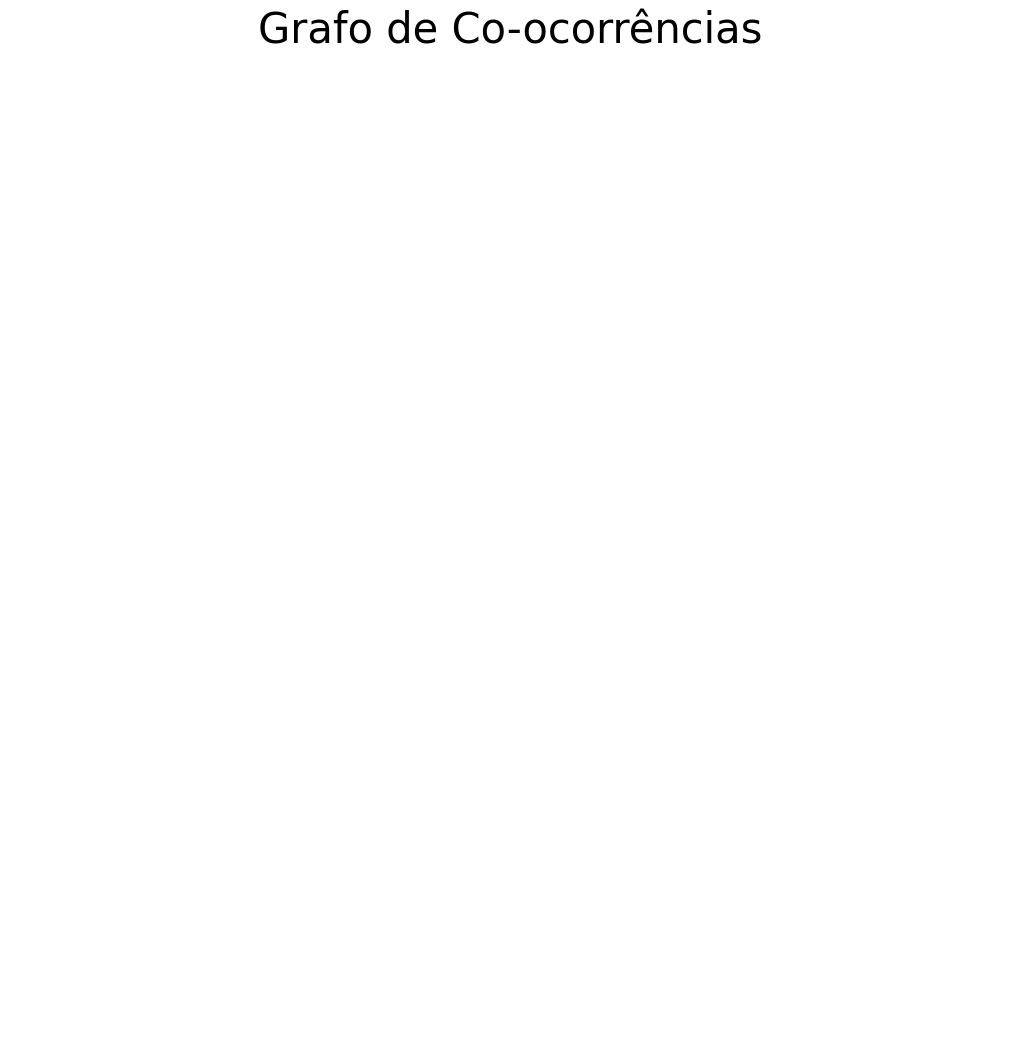

### Sugestões de Termos de Busca

- **Not Found**


In [7]:
focus_terms = ['v-']  # Substitua pelos termos de interesse

analyzer = CoOcurrence(df['Abstract'], focus_terms,svg_name='grafo_omiec_oect_neuromorphic.svg')
analyzer.analyze()

In [27]:
display(Markdown(df['Abstract'][40]))

Organic electrochemical transistors (OECTs) using aqueous gate dielectrics have garnered significant interest for bioelectronic applications. However, their viability for long-term use in neuromorphic computing and synaptic devices is limited due to their short-term functionality. In this study, we synthesize two benzodifurandione-based oligo ( p -phenylene vinylene) polymers, BDOPV-TCNVT and ClBDOPV-TCNVT, and investigate their electrochemical transistor properties using quasi -solid-state ion gel -gated vertical OECTs ( v -OECTs). Compared to BDOPV-TCNVT, the chlorinated ClBDOPV-TCNVT demonstrates lower frontier molecular orbitals and easier electrochemical doping. The higher volumetric capacitance of as -spun ClBDOPV-TCNVT (1.94 F cm -3 ) compared to as -spun BDOPV-TCNVT films (1.49 F cm -3 ) is mainly attributed to the easier ion infiltration resulting from its lower crystallinity with mixed chain orientation. The quasi -solid-state v -OECTs based on both polymers (as -spun) exhibit transconductance ( g m ) of 0.06 -0.08 mS. Following thermal treatments, the g m gradually decreases for both polymers due to enhanced edge -on ordering with tight interchain packing, hindering ion penetration. Despite the poor electrochemical doping by quasi -solid-state ion gel gated dielectrics, the enlarged area and decreased channel length in v- OECTs (compared to parallel OECTs) can enhance the g m . Further optimization of v- OECTs requires tailored material designs specifically suited for efficient vertical charge transport together with ion infiltration.